In [2]:
#!unzip "./TodosComics2.zip" -d "./"

# IMPORTS

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import ast

In [147]:
comics = pd.read_csv("TodosComics.csv", index_col=0)
characters = pd.read_csv("TodosPersonagens.csv", index_col=0)
creators = pd.read_csv("TodosCreators.csv", index_col=0)
events = pd.read_csv("TodosEvents.csv", index_col=0)
series = pd.read_csv("TodosSeries.csv", index_col=0)

# FUNCTIONS

In [5]:
def categorize_duration(years):
    if years > 25:
        return "Durou mais que 25 anos"
    elif years >= 15 and years <= 25:
        return "Durou entre 25 e 15 anos"
    elif years < 15 and years >= 5:
        return "Durou entre 14 e 5 anos"
    else:
        return "Durou menos que 5 anos"

In [107]:
def get_onsale_year(date_str):
    try:
        date_list = ast.literal_eval(date_str)  # Convert string to list of dicts safely
        for d in date_list:
            if d['type'] == 'onsaleDate':
                return d['date'][:4]  # Return only the year part
    except (ValueError, SyntaxError, TypeError):
        return None  # If it fails, return None

# INSIGHTS

## Colunas NaN

In [120]:
Nan_relation = {}
for col in comics.columns:
  Nan_relation[col] = comics[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])
df = df[df["Quantidade"] > 0]

fig = px.bar(df, x='Colunas', y='Quantidade',
             color="Colunas",
             template="presentation",
             labels={'Colunas': 'Colunas', 'Quantidade': 'Frequência de Nulos'},
             title="Quantidade de valores nulos por coluna em Comics")

fig.update_layout(xaxis_tickangle=-15)
fig.show()

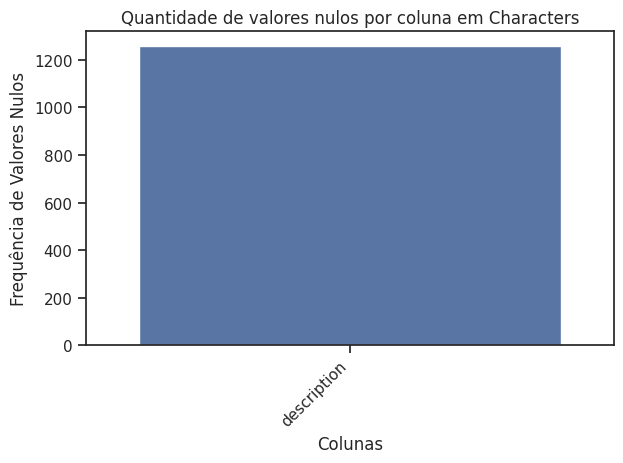

In [121]:
Nan_relation = {}
for col in characters.columns:
  Nan_relation[col] = characters[col].isna().sum()

df = pd.DataFrame(list(Nan_relation.items()), columns=['Colunas', 'Quantidade'])
df = df[df["Quantidade"] > 0]

sns.set_theme(style='ticks')
sns.barplot(data=df, x="Colunas", y="Quantidade")
plt.xlabel("Colunas")
plt.ylabel("Frequência de Valores Nulos")
plt.title("Quantidade de valores nulos por coluna em Characters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [122]:
characters["last_modified"] = characters["modified"].str.split('-').str[0]
personagens_modificados = characters["last_modified"].value_counts().reset_index()
personagens_modificados.columns = ["Ano", "Quantidade"]

media = personagens_modificados["Quantidade"].mean()

personagens_modificados[personagens_modificados["Quantidade"] > media]


fig = px.bar(personagens_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Characters")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [123]:
comics["last_modified"] = comics["modified"].str.split('-').str[0]
comics_modificados = comics["last_modified"].value_counts().reset_index()
comics_modificados.columns = ["Ano", "Quantidade"]

media = abs(comics_modificados["Quantidade"].mean())

comics_modificados[comics_modificados["Quantidade"] > media]

fig = px.bar(comics_modificados, x='Ano', y='Quantidade',
             color="Ano",
             template="presentation",
             labels={'Colunas': 'Ano de Modificação', 'Quantidade': 'Quantidade de Modificações'},
             title="Quantidade de modificações por ano em Comics")

fig.update_layout(xaxis_tickangle=-45)
fig.show()

## PERSONAGENS COM APARIÇÃO ACIMA DA MÉDIA

In [124]:
most_comics_characters = characters[characters["comics.available"] > characters["comics.available"].mean()]

In [125]:
media_de_aparicao = characters["comics.available"].mean()

In [126]:
print(f"Existem {len(most_comics_characters)} personagens, com aparições acima da média (acima de {int(media_de_aparicao)} aparições)")

Existem 280 personagens, com aparições acima da média (acima de 65 aparições)


In [127]:
print("Personagens que mais aparecem")
most_comics_characters[["name", "description", "comics.available", "stories.available",  "events.available"]].sort_values("comics.available", ascending=False).head(10).reset_index(drop=True)

Personagens que mais aparecem


,name,description,comics.available,stories.available,events.available
0,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4533,6588,37
1,X-Men,Feared and hated by humans because they're dif...,4113,5820,43
2,Wolverine,Born with super-human senses and the power to ...,2761,3811,44
3,Iron Man,"Wounded, captured and forced to build a weapon...",2745,4098,31
4,Captain America,"Vowing to serve his country any way he could, ...",2545,3723,30
5,Avengers,Earth's Mightiest Heroes joined forces to take...,2298,3129,32
6,Thor,"As the Norse God of thunder and lightning, Tho...",1903,2827,27
7,Hulk,Caught in a gamma bomb explosion while trying ...,1777,2710,26
8,Fantastic Four,"After being exposed to cosmic rays, Reed Richa...",1564,2437,24
9,Daredevil,"Abandoned by his mother, Matt Murdock was rais...",1286,1994,17


In [128]:
print("Personagens que menos aparecem")
most_comics_characters[["name", "description", "comics.available", "stories.available",  "events.available"]].sort_values("comics.available", ascending=True).head(10).reset_index(drop=True)

Personagens que menos aparecem


,name,description,comics.available,stories.available,events.available
0,Spider-Man (Ben Reilly),NaN,66,68,1
1,Penance (Robert Baldwin),NaN,66,84,6
2,Omega Red,NaN,66,76,1
3,Spider-Ham (Larval Earth),As Spider-Ham Peter faced such nefarious foes ...,67,68,0
4,Fantomex,NaN,67,74,4
5,Dum Dum Dugan,NaN,67,84,3
6,Storm (Ultimate),"Ororo Munroe was raised in Morocco, learning E...",67,122,0
7,Cyclops (Ultimate),NaN,67,121,0
8,Iceman (Ultimate),NaN,67,118,0
9,Annihilus,NaN,67,85,1


In [129]:
nao_possuem_desc = len(most_comics_characters[most_comics_characters["description"].isna()])
possuem_desc = len(most_comics_characters[~most_comics_characters["description"].isna()])

print(f"A quantidade de personagens que têm a descrição nula é: {nao_possuem_desc}")
print(f"A quantidade de personagens que não têm a descrição nula é: {possuem_desc}")

A quantidade de personagens que têm a descrição nula é: 205
A quantidade de personagens que não têm a descrição nula é: 75


In [130]:
most_comics_characters["Has_Desc"] = most_comics_characters["description"].apply(lambda x: 0 if pd.isna(x) else 1)

<ipython-input-130-a5472f3b1012>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



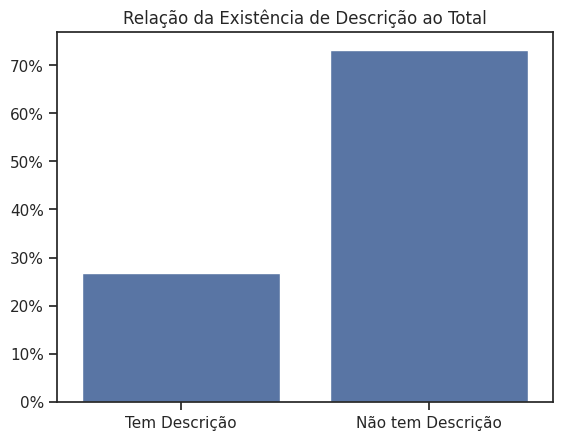

In [131]:
sns.barplot(x=["Tem Descrição", "Não tem Descrição"], y=[(possuem_desc/len(most_comics_characters))*100, (nao_possuem_desc/len(most_comics_characters))*100])
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.title("Relação da Existência de Descrição ao Total")
plt.show()

In [132]:
corr_cols = round(float(most_comics_characters["Has_Desc"].corr(most_comics_characters["comics.available"])),2)
print(f"A correlação entre ter descrição e a quantidade de quadrinhos disponíveis deste personagem é de {corr_cols}")

A correlação entre ter descrição e a quantidade de quadrinhos disponíveis deste personagem é de 0.27


In [167]:
comics['onsale_year'] = comics['dates'].apply(get_onsale_year)
comics['onsale_year'] = comics['onsale_year'].astype(int)
comics = comics[(comics['onsale_year'] >= 1900) & (comics['onsale_year'] <= 2025)]

In [150]:
aux = 1
price_year = pd.DataFrame(columns=["Preco", "Ano"])
for year in comics["onsale_year"].unique():
  for price in comics[comics["onsale_year"] == year]["prices"].values:
    #aux = comics[comics["last_modified"] == year]["prices"][1]
    aux = price
    aux = aux.strip("[]")
    aux = aux.split("'price':")[1]
    aux = aux.strip("}")
    aux = aux.split(" ")[1]
    aux = aux.split("}")[0]
    aux = float(aux)

    price_year.loc[len(price_year)] = [aux, year]
#aux

In [151]:
#TO DO: histograma de preço com hue=ano

In [169]:
print(len(price_year))
print(len(price_year[price_year["Preco"]>0]))

63702
39395


In [153]:
comics = pd.concat([comics, price_year["Preco"]], axis=1)


In [154]:
media_precos = price_year.groupby("Ano")["Preco"].mean().reset_index()
media_precos_maior_zero = price_year[price_year["Preco"] > 0].groupby("Ano")["Preco"].mean().reset_index()

In [174]:
media_precos_maior_zero["Ano"] = media_precos_maior_zero["Ano"].astype(int)
media_precos_maior_zero["Preco"] = media_precos_maior_zero["Preco"].astype(int)

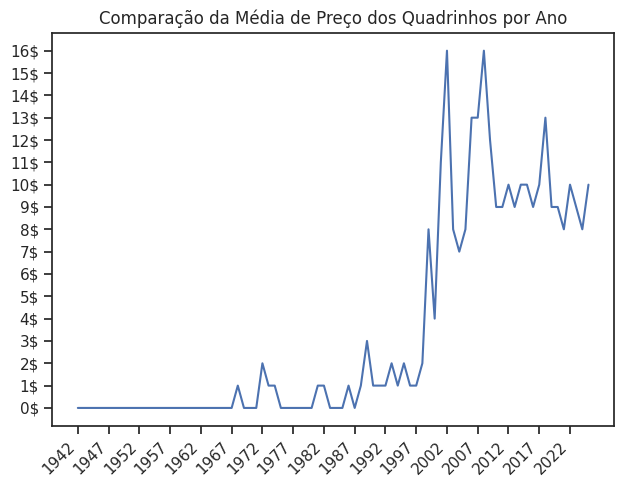

In [227]:
import matplotlib.ticker as mtick

sns.lineplot(data=media_precos_maior_zero, x='Ano', y='Preco', markers=True, dashes=False)
plt.title("Comparação da Média de Preço dos Quadrinhos por Ano")
plt.xlabel("")
plt.ylabel("")

min_year = media_precos_maior_zero['Ano'].min()
max_year = media_precos_maior_zero['Ano'].max()

min_price = int(media_precos_maior_zero['Preco'].min())
max_price = int(media_precos_maior_zero['Preco'].max())

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}$'))

plt.tight_layout()
plt.xticks(rotation=45, ha='right', ticks=range(min_year, max_year+1, 5))
plt.yticks(ticks=range(min_price, max_price+1, 1))
plt.show()


In [240]:
print(comics["stories.available"].mean())

2.4961696650026686


In [222]:
print(len(comics[comics["stories.available"] > 0]))
print(len(comics[comics["stories.available"] > comics["stories.available"].mean()]))

63690
10107


In [245]:
soma_historias_zero = comics[comics["stories.available"] > 0].groupby("onsale_year")["stories.available"].sum().reset_index()
soma_historias_media = comics[comics["stories.available"] > comics["stories.available"].mean()].groupby("onsale_year")["stories.available"].sum().reset_index()

In [258]:
soma_historias_zero["onsale_year"] = soma_historias_zero["onsale_year"].astype('category')
soma_historias_media["onsale_year"] = soma_historias_media["onsale_year"].astype('category')

soma_historias_zero["decade"] = (soma_historias_zero["onsale_year"].astype(int) // 10) * 10
soma_historias_media["decade"] = (soma_historias_media["onsale_year"].astype(int) // 10) * 10

soma_historias_zero["decade"] = soma_historias_zero["decade"].astype("category")
soma_historias_media["decade"] = soma_historias_media["decade"].astype("category")

soma_historias_zero_decade = soma_historias_zero.groupby("decade", as_index=False)["stories.available"].mean()
soma_historias_media_decade = soma_historias_media.groupby("decade", as_index=False)["stories.available"].mean()

soma_historias_zero["onsale_year"] = soma_historias_zero["onsale_year"].astype(int)
soma_historias_media["onsale_year"] = soma_historias_media["onsale_year"].astype(int)

<ipython-input-258-230c7b18eb7b>:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-258-230c7b18eb7b>:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



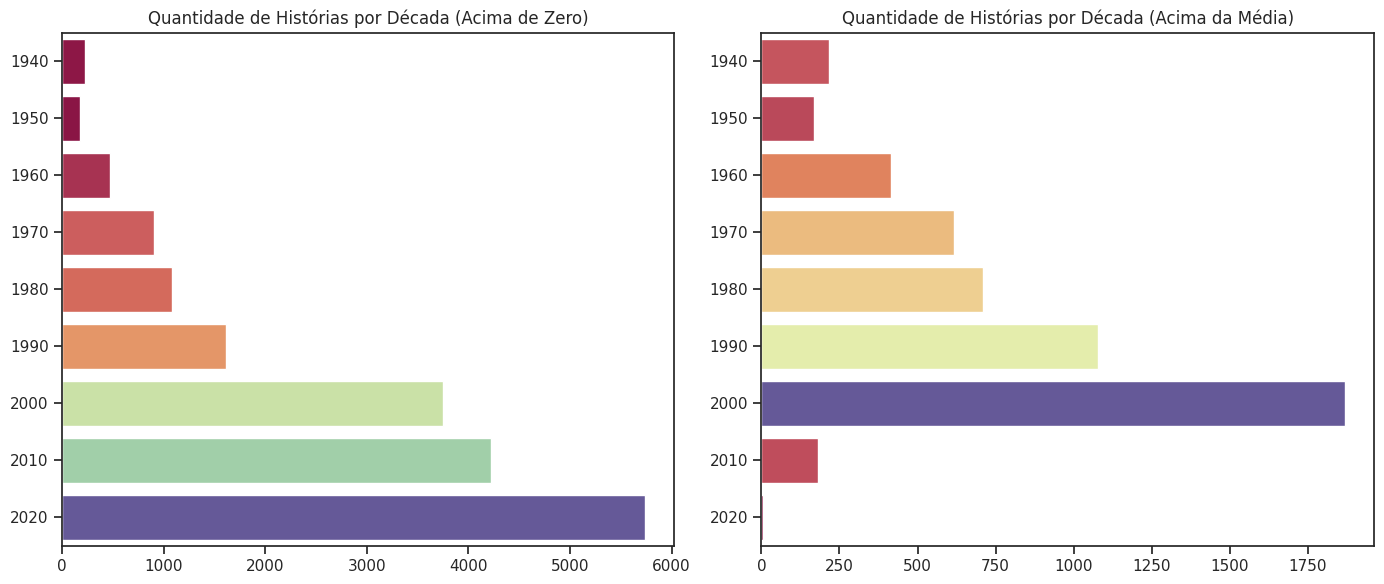

In [259]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=soma_historias_zero_decade, y='decade', x='stories.available', palette='Spectral', hue="stories.available", ax=axes[0])
axes[0].set_title("Quantidade de Histórias por Década (Acima de Zero)")
axes[0].legend_.remove()
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.barplot(data=soma_historias_media_decade, y='decade', x='stories.available', palette='Spectral', hue="stories.available", ax=axes[1])
axes[1].set_title("Quantidade de Histórias por Década (Acima da Média)")
axes[1].legend_.remove()
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [260]:
media_historias_zero = comics[comics["stories.available"] > 0].groupby("onsale_year")["stories.available"].mean().reset_index()
media_historias_media = comics[comics["stories.available"] > comics["stories.available"].mean()].groupby("onsale_year")["stories.available"].mean().reset_index()

media_historias_zero["onsale_year"] = media_historias_zero["onsale_year"].astype('category')
media_historias_media["onsale_year"] = media_historias_media["onsale_year"].astype('category')

media_historias_zero["decade"] = (media_historias_zero["onsale_year"].astype(int) // 10) * 10
media_historias_media["decade"] = (media_historias_media["onsale_year"].astype(int) // 10) * 10

media_historias_zero["decade"] = media_historias_zero["decade"].astype("category")
media_historias_media["decade"] = media_historias_media["decade"].astype("category")

media_historias_zero_decade = media_historias_zero.groupby("decade", as_index=False)["stories.available"].mean()
media_historias_media_decade = media_historias_media.groupby("decade", as_index=False)["stories.available"].mean()

media_historias_zero["onsale_year"] = media_historias_zero["onsale_year"].astype(int)
media_historias_media["onsale_year"] = media_historias_media["onsale_year"].astype(int)

<ipython-input-260-d7d1c535cdaf>:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-260-d7d1c535cdaf>:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



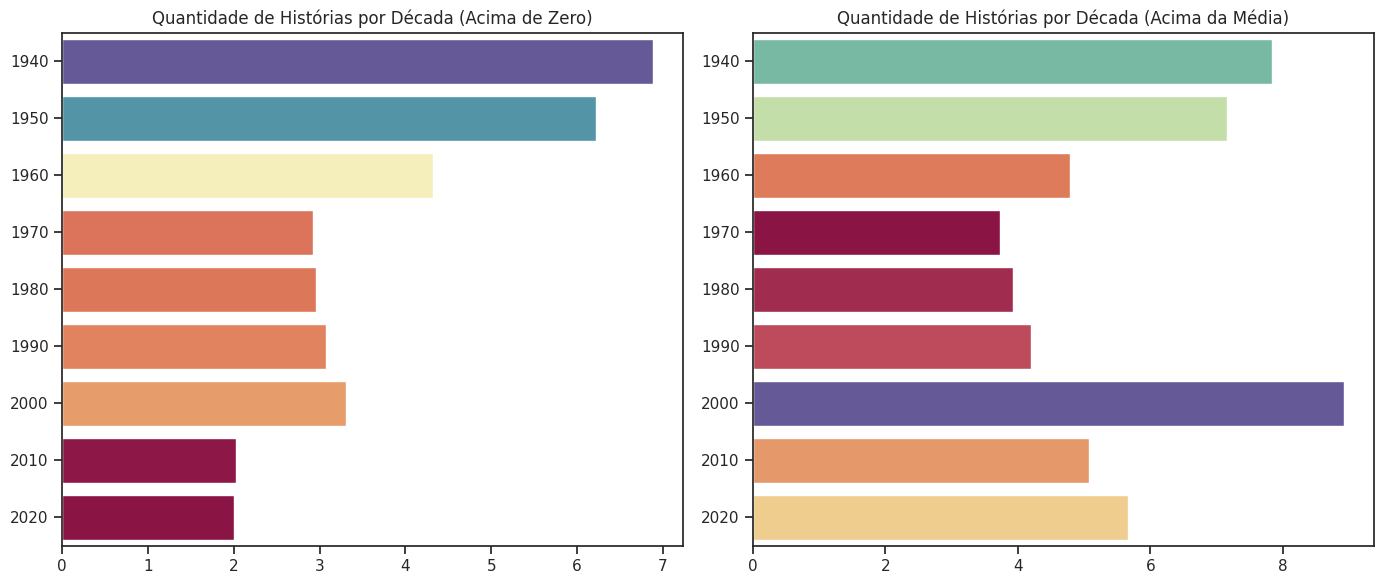

In [253]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=media_historias_zero_decade, y='decade', x='stories.available', palette='Spectral', hue="stories.available", ax=axes[0])
axes[0].set_title("Média de Histórias por Década (Acima de Zero)")
axes[0].legend_.remove()
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.barplot(data=media_historias_media_decade, y='decade', x='stories.available', palette='Spectral', hue="stories.available", ax=axes[1])
axes[1].set_title("Média de Histórias por Década (Acima da Média)")
axes[1].legend_.remove()
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [238]:
media_historias["onsale_year"] = media_historias["onsale_year"].astype(int)

In [256]:
media_historias_zero

,onsale_year,stories.available,decade
0,1940,6.480000,1940
1,1941,7.150000,1940
2,1942,8.636364,1940
3,1943,7.714286,1940
4,1944,7.485714,1940
...,...,...,...
81,2021,2.003623,2020
82,2022,2.000316,2020
83,2023,2.000000,2020
84,2024,2.000000,2020


<ipython-input-268-d5060b4f1266>:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-268-d5060b4f1266>:21: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



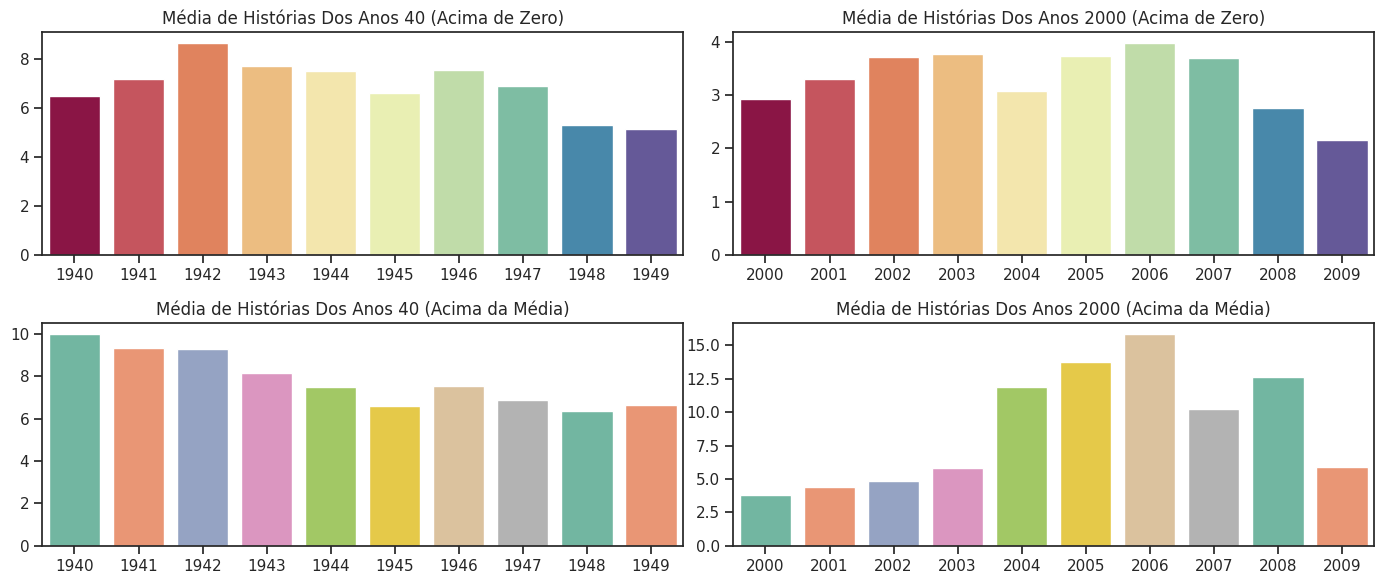

In [268]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
# ROW 0
sns.barplot(data=media_historias_zero[(media_historias_zero["onsale_year"] >=1940) & (media_historias_zero["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='Spectral', hue="onsale_year", ax=axes[0][0])
axes[0][0].set_title("Média de Histórias Dos Anos 40 (Acima de Zero)")
axes[0][0].legend_.remove()
axes[0][0].set_xlabel("")
axes[0][0].set_ylabel("")

sns.barplot(data=media_historias_zero[(media_historias_zero["onsale_year"] >=2000) & (media_historias_zero["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='Spectral', hue="onsale_year", ax=axes[0][1])
axes[0][1].set_title("Média de Histórias Dos Anos 2000 (Acima de Zero)")
axes[0][1].legend_.remove()
axes[0][1].set_xlabel("")
axes[0][1].set_ylabel("")
# ROW 1
sns.barplot(data=media_historias_media[(soma_historias_zero["onsale_year"] >=1940) & (media_historias_zero["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='Set2', hue="onsale_year", ax=axes[1][0])
axes[1][0].set_title("Média de Histórias Dos Anos 40 (Acima da Média)")
axes[1][0].legend_.remove()
axes[1][0].set_xlabel("")
axes[1][0].set_ylabel("")

sns.barplot(data=media_historias_media[(soma_historias_zero["onsale_year"] >=2000) & (media_historias_zero["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='Set2', hue="onsale_year", ax=axes[1][1])
axes[1][1].set_title("Média de Histórias Dos Anos 2000 (Acima da Média)")
axes[1][1].legend_.remove()
axes[1][1].set_xlabel("")
axes[1][1].set_ylabel("")

plt.tight_layout()
plt.show()

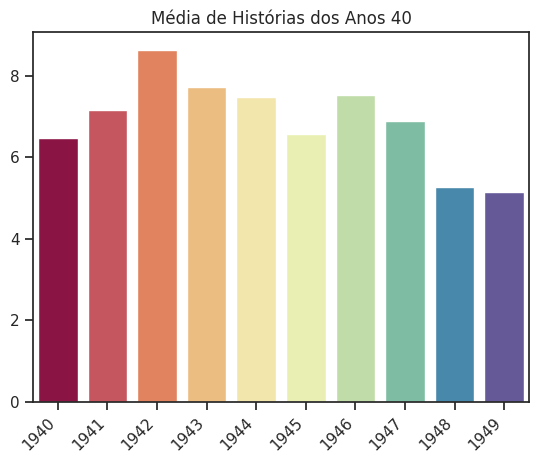

In [261]:
ax = sns.barplot(data=media_historias_zero[(media_historias_zero["onsale_year"] >=1940) & (media_historias_zero["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='Spectral', hue="onsale_year")
plt.title("Média de Histórias dos Anos 40")
ax.legend_.remove()
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.ylabel("")

plt.show()

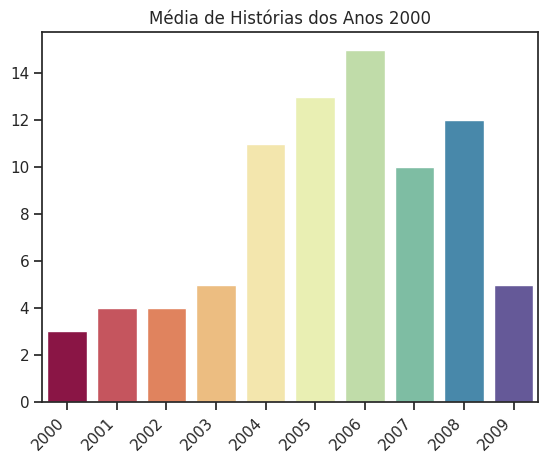

In [216]:
ax = sns.barplot(data=media_historias[(media_historias["onsale_year"] >=2000) & (media_historias["onsale_year"] <= 2009)], x='onsale_year', y='stories.available', palette='Spectral', hue="onsale_year")
plt.title("Média de Histórias dos Anos 2000")
ax.legend_.remove()
plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.ylabel("")

plt.show()

In [ ]:
#Talvez Remover
sns.barplot(data=media_historias[(media_historias["onsale_year"] >=1940) & (media_historias["onsale_year"] <= 1949)], x='onsale_year', y='stories.available', palette='Spectral')
plt.title("Média de Histórias dos Anos 40")

plt.xticks(rotation=45, ha='right')
plt.xlabel("")
plt.ylabel("")

plt.show()

<ipython-input-33-6d8e7764612e>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




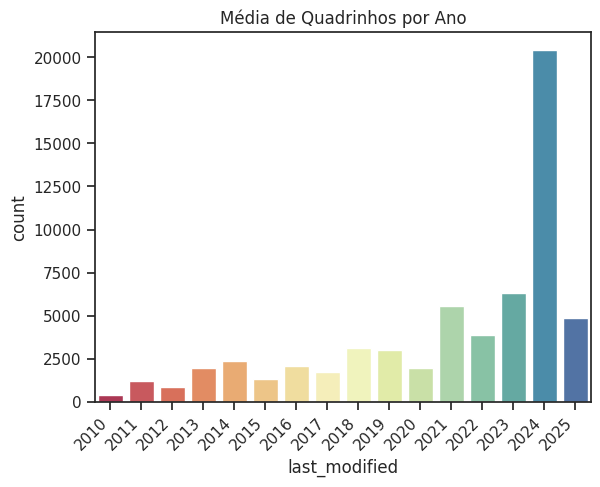

In [33]:
#Talvez Remover
sns.countplot(data=comics, x='last_modified', palette='Spectral')
plt.title("Média de Quadrinhos por Ano")
plt.xticks(rotation=45, ha='right')
plt.show()

In [74]:
comics.columns

Index(['id', 'digitalId', 'title', 'issueNumber', 'variantDescription',
       'description', 'modified', 'isbn', 'upc', 'diamondCode', 'ean', 'issn',
       'format', 'pageCount', 'textObjects', 'resourceURI', 'urls', 'variants',
       'collections', 'collectedIssues', 'dates', 'prices', 'images',
       'series.resourceURI', 'series.name', 'thumbnail.path',
       'thumbnail.extension', 'creators.available', 'creators.collectionURI',
       'creators.items', 'creators.returned', 'characters.available',
       'characters.collectionURI', 'characters.items', 'characters.returned',
       'stories.available', 'stories.collectionURI', 'stories.items',
       'stories.returned', 'events.available', 'events.collectionURI',
       'events.items', 'events.returned', 'last_modified', 'Preco'],
      dtype='object')

In [78]:
series[series["title"] == "Marvel Previews (2017 - Present)"]

,id,title,description,resourceURI,urls,startYear,endYear,rating,type,modified,...,comics.items,comics.returned,events.available,events.collectionURI,events.items,events.returned,next.resourceURI,next.name,previous.resourceURI,previous.name
7621,23665,Marvel Previews (2017 - Present),NaN,https://gateway.marvel.com/v1/public/series/23665,"[{'type': 'detail', 'url': 'http://marvel.com/...",2017,2099,NaN,NaN,2020-02-07T09:35:58+0000,...,[{'resourceURI': 'https://gateway.marvel.com/v...,13,0,https://gateway.marvel.com/v1/public/series/23...,[],0,NaN,NaN,NaN,NaN


,startYear,comic_count
0,2008,2.0
1,2021,1.0
2,2019,1.0
3,2014,5.0
4,2011,3.0
5,2013,1.0
6,2015,NaN
7,2016,1.0
8,2015,8.0
9,2015,7.0


In [75]:
comics["series.name"]

,series.name
0,Marvel Previews (2017 - Present)
1,Marvel Previews (2017 - Present)
2,Marvel Previews (2017 - Present)
3,The Punisher (2016 - 2018)
4,MARVELS (1994)
...,...
64207,Storm (0000 - Present)
64209,ULTIMATE X-MEN: HELLFIRE & BRIMSTONE (2003 - P...
64210,Fantastic Four 1 2 3 4 (2001)
64252,Giant-Size Astonishing X-Men (2008)


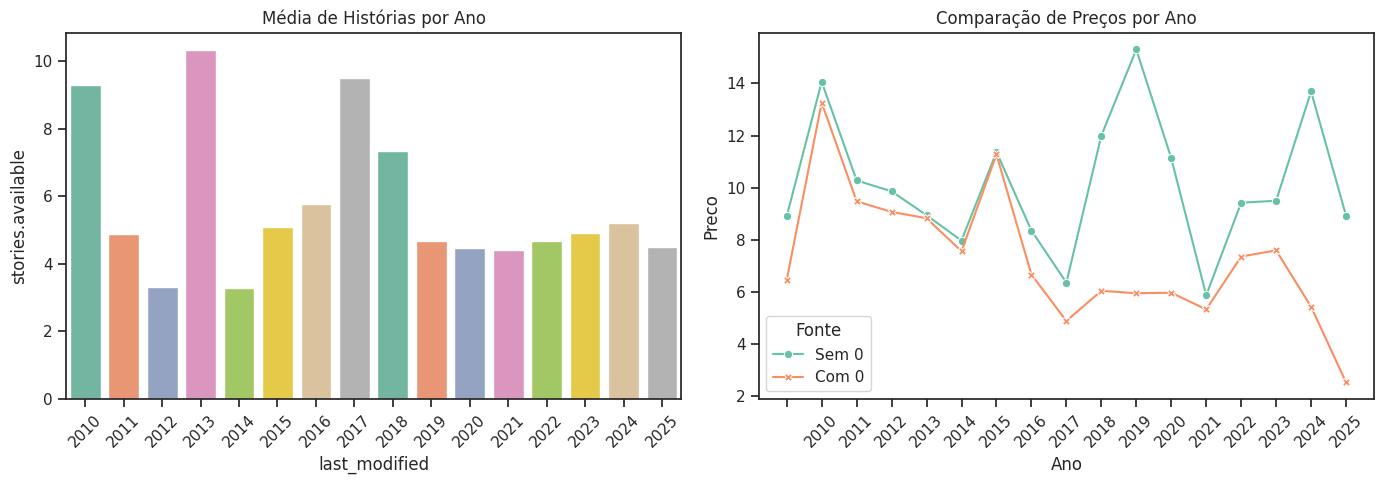

In [35]:
#Talvez remover
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

sns.barplot(data=media_historias, x='last_modified', y='stories.available', ax=axes[0], palette='Set2', hue='last_modified', legend=False)
axes[0].set_title('Média de Histórias por Ano')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_long, x='Ano', y='Preco', hue='Fonte', markers=True, style='Fonte', dashes=False, ax=axes[1], palette='Set2')
axes[1].set_title('Comparação de Preços por Ano')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [36]:
creators = creators[~creators["fullName"].isna()]

In [37]:
cols = ["fullName", "events.available", "stories.available"]
most_events = creators[cols].sort_values("events.available", ascending=False).head(25)
most_events.head(7)

,fullName,events.available,stories.available
955,Vc Joe Caramagna,29,12553
2095,Scott Hanna,21,2051
1362,Frank D'ARMATA,21,2680
3791,Vc Cory Petit,20,8984
3630,Tom Palmer,19,1176
1680,Vc Chris Eliopoulos,19,2435
1402,Peter David,18,1718


<ipython-input-73-363ac59f838b>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




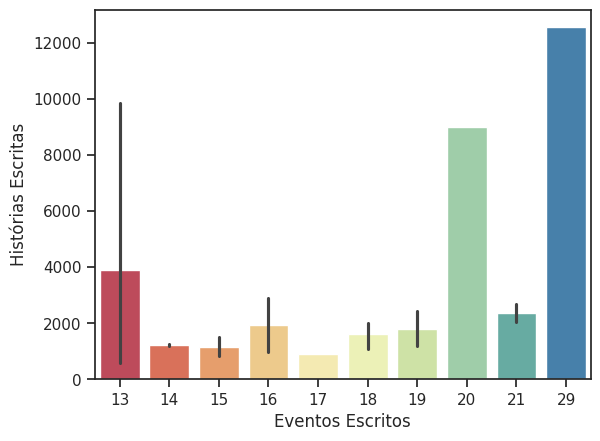

In [73]:
sns.barplot(data=most_events, x="events.available", y="stories.available", palette='Spectral')
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.show()

In [39]:
cols = ["id", "fullName", "stories.available", "events.available"]
most_stories = creators[cols].sort_values("stories.available", ascending=False).head(25)
most_stories.head(15)

,id,fullName,stories.available,events.available
5282,4430,Jeff Youngquist,17934,8
955,5251,Vc Joe Caramagna,12553,29
726,2133,Tom Brevoort,9861,13
3791,12980,Vc Cory Petit,8984,20
3645,4600,Mark Paniccia,8917,10
1290,10172,Vc Clayton Cowles,8910,11
3112,4300,Nick Lowe,7630,13
3403,12376,Wilson Moss,5770,3
2848,12993,Vc Travis Lanham,5708,5
4210,12974,Vc Joe Sabino,5501,5


In [71]:
most_stories["id"].head(7).to_xarray()

<xarray.DataArray 'id' (index: 7)> Size: 56B
array([ 4430,  5251,  2133, 12980,  4600, 10172,  4300])
Coordinates:
  * index    (index) int64 56B 5282 955 726 3791 3645 1290 3112

In [41]:
comics.loc[59739]["creators.items"]

"[{'resourceURI': 'https://gateway.marvel.com/v1/public/creators/954', 'name': 'Gerry Conway', 'role': 'writer'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/946', 'name': 'Jim Shooter', 'role': 'writer'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1746', 'name': 'John Costanza', 'role': 'letterer'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1420', 'name': 'Bruce Patterson', 'role': 'letterer'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1754', 'name': 'Gaspar Saladino', 'role': 'letterer'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1311', 'name': 'Lee Elias', 'role': 'penciller'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1178', 'name': 'Archie Goodwin', 'role': 'editor'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1326', 'name': 'Dan Green', 'role': 'inker'}, {'resourceURI': 'https://gateway.marvel.com/v1/public/creators/1240', 'name': 'Joe Sin

<ipython-input-43-2954a9e427be>:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




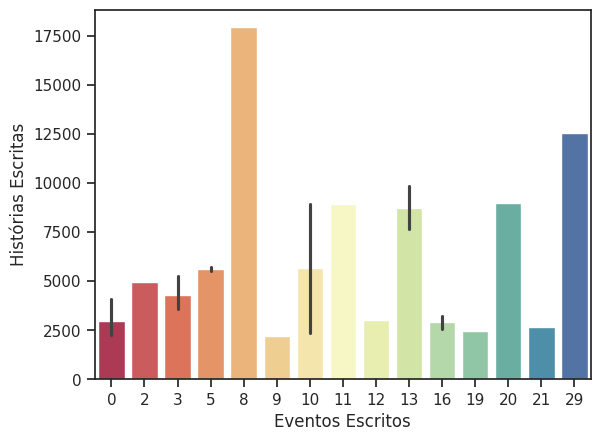

In [43]:
sns.barplot(data=most_stories, x="events.available", y="stories.available", palette="Spectral")
plt.xlabel("Eventos Escritos")
plt.ylabel("Histórias Escritas")
plt.show()

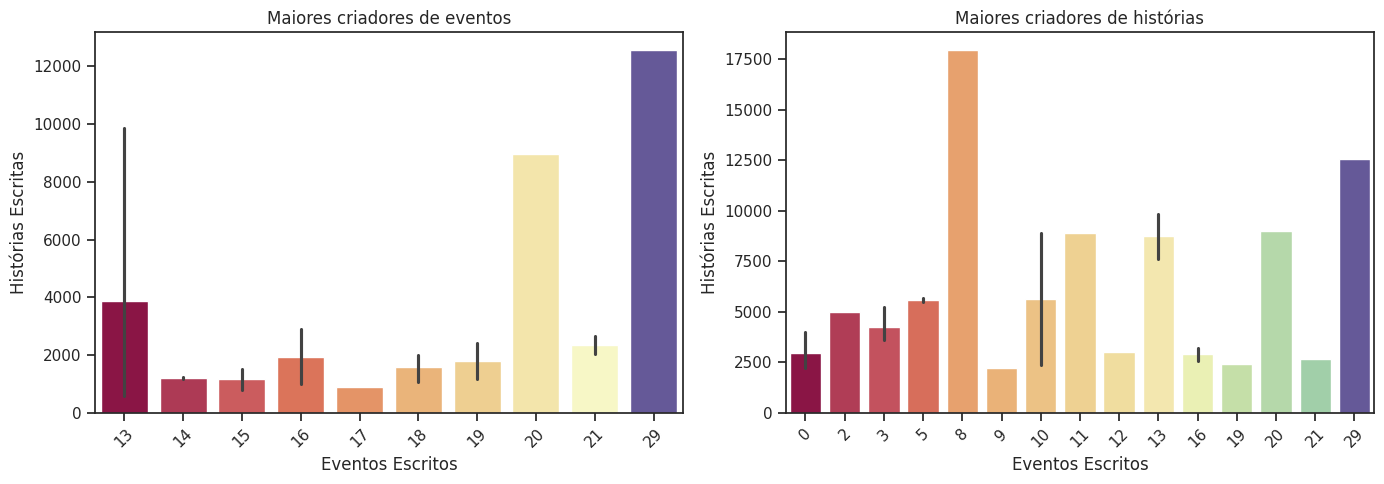

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

sns.barplot(data=most_events, x="events.available", y="stories.available", palette='Spectral', ax=axes[0], hue="events.available", legend=False)
axes[0].set_title("Maiores criadores de eventos")
axes[0].set_xlabel("Eventos Escritos")
axes[0].set_ylabel("Histórias Escritas")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(data=most_stories, x="events.available", y="stories.available", palette="Spectral", ax=axes[1], hue="events.available", legend=False)
axes[1].set_title("Maiores criadores de histórias")
axes[1].set_xlabel("Eventos Escritos")
axes[1].set_ylabel("Histórias Escritas")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [45]:
stories_index = most_stories.index
events_index = most_events.index
combined = []
for author in stories_index:
  if author in events_index:
    combined.append(author)
len(combined)

7

In [46]:
most_stories.loc[combined]

,id,fullName,stories.available,events.available
955,5251,Vc Joe Caramagna,12553,29
726,2133,Tom Brevoort,9861,13
3791,12980,Vc Cory Petit,8984,20
4513,350,Richard Starkings,3236,16
1362,8504,Frank D'ARMATA,2680,21
515,24,Brian Michael Bendis,2551,16
1680,12581,Vc Chris Eliopoulos,2435,19


In [47]:
most_stories.index

Index([5282,  955,  726, 3791, 3645, 1290, 3112, 3403, 2848, 4210, 5161,  451,
       2998, 2941, 5160, 4513, 1462, 1362, 3196,  515, 1680,  799,  208, 1669,
       1502],
      dtype='int64')

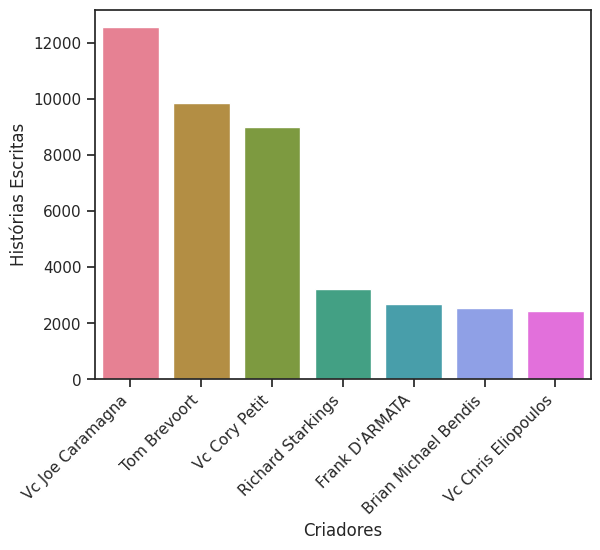

In [48]:
sns.barplot(data=most_stories.loc[combined], x="fullName", y="stories.available", palette="husl", hue="fullName")
plt.xlabel("Criadores")
plt.ylabel("Histórias Escritas")
plt.xticks(rotation=45, ha='right')
plt.show()

In [50]:
events.head()

,id,title,description,resourceURI,urls,modified,start,end,thumbnail.path,thumbnail.extension,...,series.available,series.collectionURI,series.items,series.returned,next.resourceURI,next.name,previous.resourceURI,previous.name,next,previous
0,116,Acts of Vengeance!,Loki sets about convincing the super-villains ...,https://gateway.marvel.com/v1/public/events/116,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-06-28T16:31:24+0000,1989-12-10 00:00:00,2008-01-04 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/9/40/51...,jpg,...,21,https://gateway.marvel.com/v1/public/events/11...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,https://gateway.marvel.com/v1/public/events/240,Days of Future Present,https://gateway.marvel.com/v1/public/events/233,Atlantis Attacks,NaN,NaN
1,227,Age of Apocalypse,"In a twisted version of the world they knew, t...",https://gateway.marvel.com/v1/public/events/227,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-08-01T11:34:39+0000,1995-03-01 00:00:00,1996-06-01 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/5/e0/51...,jpg,...,20,https://gateway.marvel.com/v1/public/events/22...,[{'resourceURI': 'https://gateway.marvel.com/v...,20,https://gateway.marvel.com/v1/public/events/239,Crossing,https://gateway.marvel.com/v1/public/events/219,Siege of Darkness,NaN,NaN
2,314,Age of Ultron,In a 10-issue event written by Brian Michael B...,https://gateway.marvel.com/v1/public/events/314,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-11-07T15:05:02+0000,2013-03-06 00:00:00,2013-06-19 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/c/10/51...,jpg,...,7,https://gateway.marvel.com/v1/public/events/31...,[{'resourceURI': 'https://gateway.marvel.com/v...,7,https://gateway.marvel.com/v1/public/events/315,Infinity,https://gateway.marvel.com/v1/public/events/311,Marvel NOW!,NaN,NaN
3,303,Age of X,In a strange reality where the X-Men never cam...,https://gateway.marvel.com/v1/public/events/303,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-06-28T18:34:27+0000,2011-01-26 00:00:00,2011-05-01 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/5/40/51...,jpg,...,4,https://gateway.marvel.com/v1/public/events/30...,[{'resourceURI': 'https://gateway.marvel.com/v...,4,https://gateway.marvel.com/v1/public/events/302,Fear Itself,https://gateway.marvel.com/v1/public/events/296,Chaos War,NaN,NaN
4,329,All-New All-Different Marvel,"This fall, prepare for an all-new, all-differe...",https://gateway.marvel.com/v1/public/events/329,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-08-01T11:34:33+0000,NaN,NaN,http://i.annihil.us/u/prod/marvel/i/mg/b/f0/55...,jpg,...,0,https://gateway.marvel.com/v1/public/events/32...,[],0,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
len_start = len(events[events["start"].isna()])
len_end = len(events[events["end"].isna()])

print(f"Quantidade de valores nulos na data de início: {len_start}")
print(f"Quantidade de valores nulos na data de fim: {len_end}")
print(f"Total de linhas: {len(events)}")

Quantidade de valores nulos na data de início: 6
Quantidade de valores nulos na data de fim: 6
Total de linhas: 73


In [52]:
events = events[~events["start"].isna()]

In [53]:
events["Ano_Inicio"] = events["start"].str.split('-').str[0].astype(int)

<ipython-input-53-262fcc1b17ca>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
events["duracao"] = events["end"].str.split('-').str[0].astype(int) - events["start"].str.split('-').str[0].astype(int)

<ipython-input-54-2c692fdfacdd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [55]:
events["categoria_duracao"] = events["duracao"].apply(categorize_duration)

<ipython-input-55-6d562ec5df83>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
events.columns

Index(['id', 'title', 'description', 'resourceURI', 'urls', 'modified',
       'start', 'end', 'thumbnail.path', 'thumbnail.extension',
       'creators.available', 'creators.collectionURI', 'creators.items',
       'creators.returned', 'characters.available', 'characters.collectionURI',
       'characters.items', 'characters.returned', 'stories.available',
       'stories.collectionURI', 'stories.items', 'stories.returned',
       'comics.available', 'comics.collectionURI', 'comics.items',
       'comics.returned', 'series.available', 'series.collectionURI',
       'series.items', 'series.returned', 'next.resourceURI', 'next.name',
       'previous.resourceURI', 'previous.name', 'next', 'previous',
       'Ano_Inicio', 'duracao', 'categoria_duracao'],
      dtype='object')

In [57]:
events[["title", "description", "duracao", "stories.available"]].sort_values(by="duracao", ascending=False)

,title,description,duracao,stories.available
50,Point One,A great jumping on point for new readers setti...,26,0
38,Kraven's Last Hunt,Frustrated with his repeated failed attempts a...,25,21
39,Marvel NOW!,The greatest creators in comics bring the best...,25,42
45,Mutant Massacre,The underground community of mutants known as ...,24,41
56,Secret Wars II,The omnipotent Beyonder comes to Earth to bett...,24,112
...,...,...,...,...
61,Spider-Island,"This summer, heroes, villains and ordinary peo...",0,62
68,X-Men: Battle of the Atom,The presence of the original X-Men in the mode...,0,20
65,War of Kings,In an effort to punish the Skrulls for their a...,0,104
70,X-Men: Schism,A new Hellfire Club unleashes Sentinels on Uto...,0,21


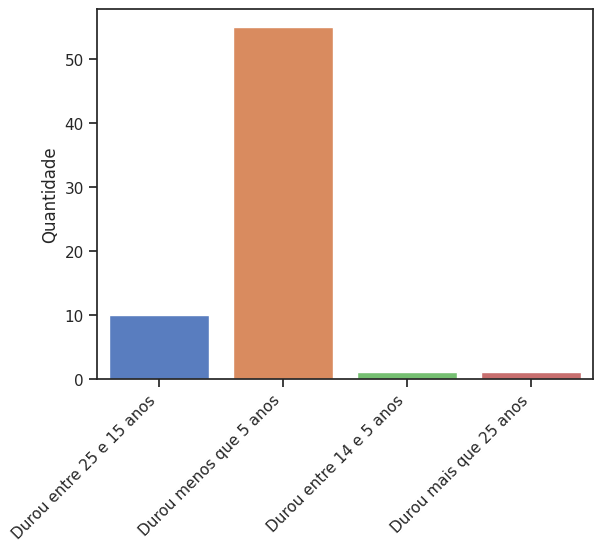

In [58]:
sns.countplot(data=events, x='categoria_duracao', palette='muted', hue="categoria_duracao")
plt.ylabel("Quantidade")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.show()

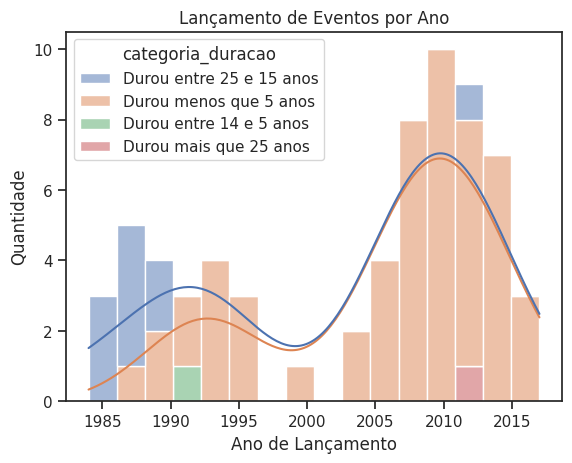

In [59]:
sns.histplot(data=events[events["Ano_Inicio"] <= 2025], x="Ano_Inicio", kde=True, binwidth=2, hue="categoria_duracao", multiple="stack")
plt.title("Lançamento de Eventos por Ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Quantidade")
plt.show()

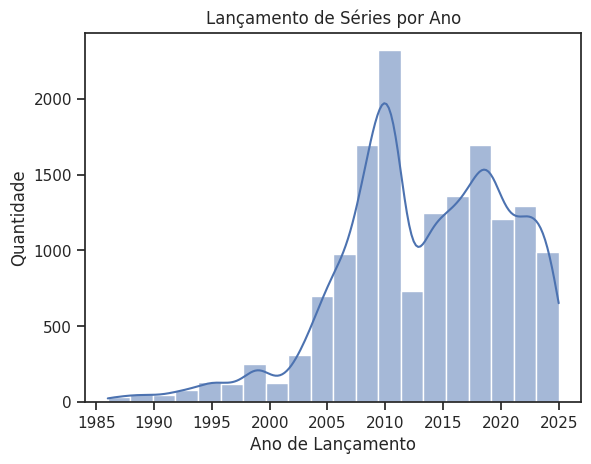

In [60]:
sns.histplot(data=series[(series["startYear"] > 1985) & (series["startYear"] <= 2025)], x="startYear", kde=True, binwidth=2)
plt.title("Lançamento de Séries por Ano")
plt.xlabel("Ano de Lançamento")
plt.ylabel("Quantidade")
plt.show()

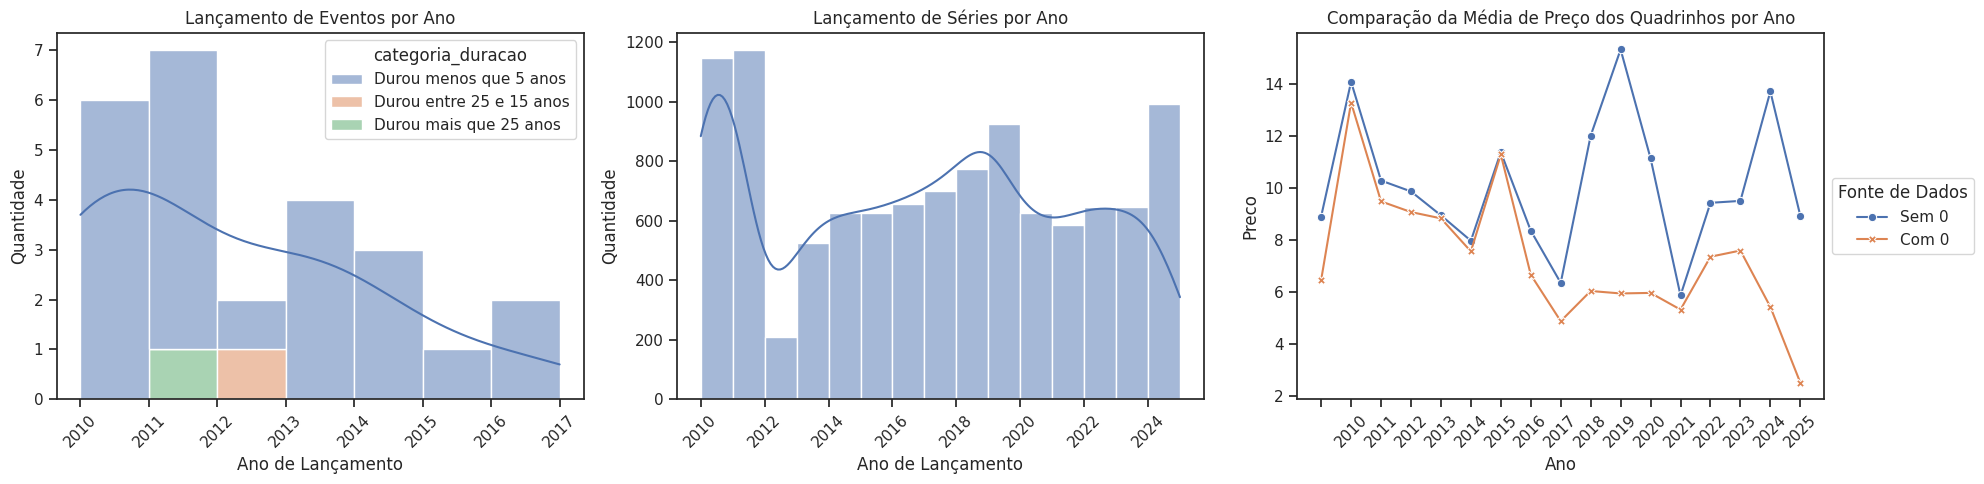

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 2 columns

sns.histplot(data=events[(events["Ano_Inicio"] <= 2025) & (events["Ano_Inicio"] >= 2010)], x="Ano_Inicio", kde=True, binwidth=1, hue="categoria_duracao", multiple="stack", ax = axes[0])
axes[0].set_title("Lançamento de Eventos por Ano")
axes[0].set_xlabel("Ano de Lançamento")
axes[0].set_ylabel("Quantidade")
axes[0].tick_params(axis='x', rotation=45)

sns.histplot(data=series[(series["startYear"] >= 2010) & (series["startYear"] <= 2025)], x="startYear", kde=True, binwidth=1, ax=axes[1])
axes[1].set_title("Lançamento de Séries por Ano")
axes[1].set_xlabel("Ano de Lançamento")
axes[1].set_ylabel("Quantidade")
axes[1].tick_params(axis='x', rotation=45)

sns.lineplot(data=df_long, x='Ano', y='Preco', hue='Fonte', markers=True, style='Fonte', dashes=False, ax=axes[2])
axes[2].set_title("Comparação da Média de Preço dos Quadrinhos por Ano")
axes[2].legend(title="Fonte de Dados", loc='center left', bbox_to_anchor=(1, 0.5))
axes[2].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

In [ ]:
# TO DO: QUANTOS COMICS CADA SERIES FEZ E RELACIONAR O ANO DE INICIO DA SERIES COM RELAÇÃO DE PREÇO?

67

In [97]:
top_series = series.sort_values(by="comics.available", ascending=False).head(10)

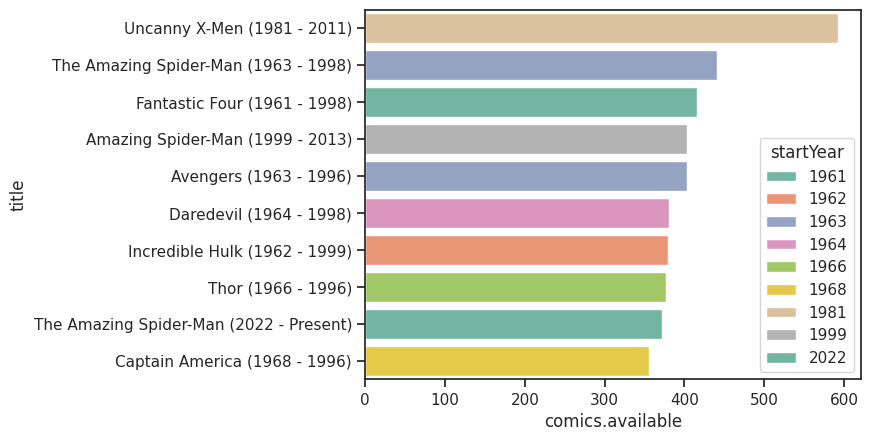

In [99]:
sns.barplot(data=top_series, x="comics.available", y="title", hue="startYear", palette="Set2")
plt.show()

In [62]:
series.head()

,id,title,description,resourceURI,urls,startYear,endYear,rating,type,modified,...,comics.items,comics.returned,events.available,events.collectionURI,events.items,events.returned,next.resourceURI,next.name,previous.resourceURI,previous.name
0,6026,(2008),NaN,https://gateway.marvel.com/v1/public/series/6026,"[{'type': 'detail', 'url': 'http://marvel.com/...",2008,2008,Rated a,NaN,2024-07-23T09:28:06+0000,...,[{'resourceURI': 'https://gateway.marvel.com/v...,2,0,https://gateway.marvel.com/v1/public/series/60...,[],0,NaN,NaN,NaN,NaN
1,31445,Fantastic Four by Dan Slott Vol. 1 (2021),NaN,https://gateway.marvel.com/v1/public/series/31445,"[{'type': 'detail', 'url': 'http://marvel.com/...",2021,2021,NaN,collection,2020-07-29T09:04:18+0000,...,[{'resourceURI': 'https://gateway.marvel.com/v...,1,0,https://gateway.marvel.com/v1/public/series/31...,[],0,NaN,NaN,NaN,NaN
2,26024,Superior Spider-Man Vol. 2: Otto-matic (2019),NaN,https://gateway.marvel.com/v1/public/series/26024,"[{'type': 'detail', 'url': 'http://marvel.com/...",2019,2019,NaN,collection,2019-12-13T16:23:45+0000,...,[{'resourceURI': 'https://gateway.marvel.com/v...,1,0,https://gateway.marvel.com/v1/public/series/26...,[],0,NaN,NaN,NaN,NaN
3,18454,100th Anniversary Special (2014),NaN,https://gateway.marvel.com/v1/public/series/18454,"[{'type': 'detail', 'url': 'http://marvel.com/...",2014,2014,Rated T,limited,2019-10-01T18:42:55+0000,...,[{'resourceURI': 'https://gateway.marvel.com/v...,5,0,https://gateway.marvel.com/v1/public/series/18...,[],0,NaN,NaN,NaN,NaN
4,13379,15-Love (2011),NaN,https://gateway.marvel.com/v1/public/series/13379,"[{'type': 'detail', 'url': 'http://marvel.com/...",2011,2011,NaN,NaN,2018-02-17T07:13:46+0000,...,[{'resourceURI': 'https://gateway.marvel.com/v...,3,0,https://gateway.marvel.com/v1/public/series/13...,[],0,NaN,NaN,NaN,NaN


In [63]:
# sns.catplot(data=events, y="series.available", x="duracao", hue="categoria_duracao")
# plt.show()

In [64]:
events.sort_values(by="stories.available", ascending=False)

,id,title,description,resourceURI,urls,modified,start,end,thumbnail.path,thumbnail.extension,...,series.returned,next.resourceURI,next.name,previous.resourceURI,previous.name,next,previous,Ano_Inicio,duracao,categoria_duracao
18,318,Dark Reign,Norman Osborn came out the hero of Secret Inva...,https://gateway.marvel.com/v1/public/events/318,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-11-20T12:51:39+0000,2008-12-01 00:00:00,2009-12-31 12:59:00,http://i.annihil.us/u/prod/marvel/i/mg/c/60/52...,jpg,...,20,https://gateway.marvel.com/v1/public/events/276,War of Kings,https://gateway.marvel.com/v1/public/events/269,Secret Invasion,NaN,NaN,2008,1,Durou menos que 5 anos
53,269,Secret Invasion,The shape-shifting Skrulls have been infiltrat...,https://gateway.marvel.com/v1/public/events/269,"[{'type': 'detail', 'url': 'http://marvel.com/...",2015-01-20T14:58:35+0000,2008-06-02 00:00:00,2009-01-25 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/6/70/51...,jpg,...,20,https://gateway.marvel.com/v1/public/events/318,Dark Reign,https://gateway.marvel.com/v1/public/events/299,Messiah CompleX,NaN,NaN,2008,1,Durou menos que 5 anos
15,238,Civil War,After a horrific tragedy raises questions on w...,https://gateway.marvel.com/v1/public/events/238,"[{'type': 'detail', 'url': 'http://marvel.com/...",2020-02-28T14:25:35+0000,2006-07-01 00:00:00,2007-01-29 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/2/d0/51...,jpg,...,20,https://gateway.marvel.com/v1/public/events/255,Initiative,https://gateway.marvel.com/v1/public/events/212,Planet Hulk,NaN,NaN,2006,1,Durou menos que 5 anos
55,323,Secret Wars (2015),Time Runs Out. Everything Ends. The Secret War...,https://gateway.marvel.com/v1/public/events/323,"[{'type': 'detail', 'url': 'http://marvel.com/...",2020-02-28T14:25:36+0000,2015-05-01 07:01:00,2015-12-31 07:59:00,http://i.annihil.us/u/prod/marvel/i/mg/c/70/54...,jpg,...,20,https://gateway.marvel.com/v1/public/events/332,Dead No More: The Clone Conspiracy,https://gateway.marvel.com/v1/public/events/321,Spider-Verse,NaN,NaN,2015,0,Durou menos que 5 anos
35,255,Initiative,"After the partial destruction of Stamford, CT,...",https://gateway.marvel.com/v1/public/events/255,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-11-18T17:38:03+0000,2007-04-15 00:00:00,2010-06-20 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/3/60/51...,jpg,...,20,https://gateway.marvel.com/v1/public/events/229,Annihilation,https://gateway.marvel.com/v1/public/events/238,Civil War,NaN,NaN,2007,3,Durou menos que 5 anos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,249,Fatal Attractions,"Magneto returns, more powerful than ever, and ...",https://gateway.marvel.com/v1/public/events/249,"[{'type': 'detail', 'url': 'http://marvel.com/...",2017-07-05T15:10:47+0000,1993-07-10 00:00:00,1993-11-10 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/f/30/51...,jpg,...,6,https://gateway.marvel.com/v1/public/events/235,Blood and Thunder,https://gateway.marvel.com/v1/public/events/151,Maximum Carnage,NaN,NaN,1993,0,Durou menos que 5 anos
27,287,Heroic Age,Still lurking in the shadows are forces of evi...,https://gateway.marvel.com/v1/public/events/287,"[{'type': 'detail', 'url': 'http://marvel.com/...",2013-11-18T17:35:22+0000,2010-04-25 00:00:00,2012-04-25 00:00:00,http://i.annihil.us/u/prod/marvel/i/mg/4/00/51...,jpg,...,2,https://gateway.marvel.com/v1/public/events/294,The Thanos Imperative,https://gateway.marvel.com/v1/public/events/279,X-Men: Second Coming,NaN,NaN,2010,2,Durou menos que 5 anos
10,322,Avengers NOW!,"Sam Wilson, formerly the Falcon, becomes the A...",https://gateway.marvel.com/v1/public/events/322,"[{'type': 'detail', 'url': 'http://marvel.com/...",2016-02-26T13:14:38+0000,2037-01-01 01:00:00,2037-01-01 01:00:00,http://i.annihil.us/u/prod/marvel/i/mg/5/c0/53...,jpg,...,0,NaN,NaN,https://gateway.marvel.com/v1/public/events/336,Secret Empire,NaN,NaN,2037,0,Durou menos que 5 anos
31,253,Infinity Gauntlet,"When the M